# Library

In [1]:
!pip install pandas

In [2]:
!pip install matplotlib

In [3]:
!pip install opendatasets

In [4]:
!pip install scikit-learn

In [5]:
# Library to dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od

# Library tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Surpress warning
import warnings
warnings.filterwarnings("ignore")

# Library sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# pickle
import pickle


# Dataset

In [6]:
# Read dataset
data = pd.read_csv('clean_text.csv')
data.head()

,text,class,clean_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threaten suiciderec left wife good che...
1,Am I weird I don't get affected by compliments...,non-suicide,weird get affect compliment come someon know i...
2,Finally 2020 is almost over... So I can never ...,non-suicide,final almost never hear bad year ever swear fu...
3,i need helpjust help me im crying so hard,suicide,need helpjust help im cri hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,losthello name adam struggl year afraid past y...


# Encoding

In [7]:
X = data['clean_text'].astype(str)
y = data['class']

# encode class values as integers
# Define label encoder
encoder = LabelEncoder()
# fit and transform
encoded_y = encoder.fit_transform(y)

# Test Train Split

In [8]:
# Test and train split
X_train, X_test, y_train, y_test = train_test_split(X,encoded_y, test_size=.2, random_state=42)

# Data Preprocessing

In [9]:
vocab_size = 10_000
max_length = 10_000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(y_train)
testing_labels = np.array(y_test)

In [10]:
# Save the word index dictionary
np.save('word_index.npy', word_index)

# Save Tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Basic Model Embeding Layers

In [11]:
embedding_dim = 16

# Initialize the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 16)         160000    
                                                                 
 flatten (Flatten)           (None, 160000)            0         
                                                                 
 dense (Dense)               (None, 128)               20480128  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 20,673,281
Trainable params: 20,673,281
No

In [12]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Basic Model Embeding Layers.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=10, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [13]:
# Define the number of epochs
num_epochs = 100

# Train the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), callbacks=callbacks)

Epoch 1/100
5799/5802 [============================>.] - ETA: 0s - loss: 0.2011 - accuracy: 0.9216
Epoch 1: val_accuracy improved from -inf to 0.93967, saving model to Basic Model Embeding Layers.h5
5802/5802 [==============================] - 51s 8ms/step - loss: 0.2011 - accuracy: 0.9216 - val_loss: 0.1629 - val_accuracy: 0.9397 - lr: 0.0010
Epoch 2/100
5798/5802 [============================>.] - ETA: 0s - loss: 0.1565 - accuracy: 0.9416
Epoch 2: val_accuracy improved from 0.93967 to 0.94030, saving model to Basic Model Embeding Layers.h5
5802/5802 [==============================] - 49s 8ms/step - loss: 0.1565 - accuracy: 0.9416 - val_loss: 0.1603 - val_accuracy: 0.9403 - lr: 0.0010
Epoch 3/100
5796/5802 [============================>.] - ETA: 0s - loss: 0.1397 - accuracy: 0.9486
Epoch 3: val_accuracy improved from 0.94030 to 0.94099, saving model to Basic Model Embeding Layers.h5
5802/5802 [==============================] - 49s 8ms/step - loss: 0.1397 - accuracy: 0.9486 - val_loss:

In [14]:
# Evaluate the model
results_base = model.evaluate(testing_padded, testing_labels)

# print results
print(f'Test results - Loss: {results_base[0]} - Accuracy: {100*results_base[1]}%')

1451/1451 [==============================] - 4s 2ms/step - loss: 0.1588 - accuracy: 0.9410
Test results - Loss: 0.15879160165786743 - Accuracy: 94.09888982772827%


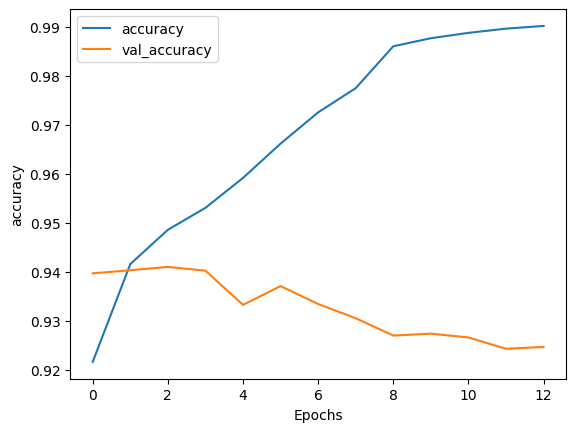

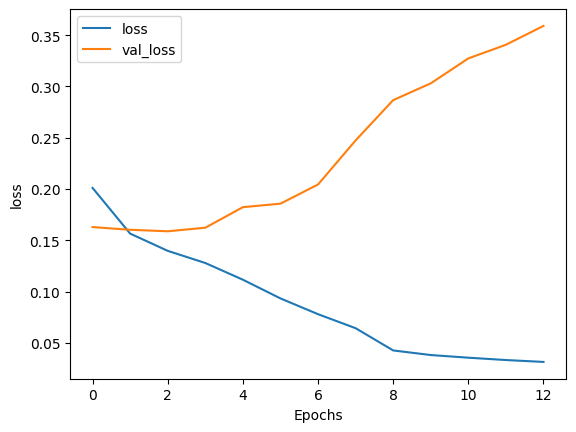

In [15]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Model Basic + Global Average Pooling

In [16]:
embedding_dim = 16

# Initialize the model
model_GlobalAveragePooling1D = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_GlobalAveragePooling1D.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_GlobalAveragePooling1D.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10000, 16)         160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 128)               2176      
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                      

In [17]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Model Basic + Global Average Pooling.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=10, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [18]:
num_epochs = 100

# Train the model
history_GlobalAveragePooling1D = model_GlobalAveragePooling1D.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), callbacks=callbacks)

Epoch 1/100
5801/5802 [============================>.] - ETA: 0s - loss: 0.4517 - accuracy: 0.7460
Epoch 1: val_accuracy improved from -inf to 0.91623, saving model to Model Basic + Global Average Pooling.h5
5802/5802 [==============================] - 32s 5ms/step - loss: 0.4517 - accuracy: 0.7461 - val_loss: 0.2283 - val_accuracy: 0.9162 - lr: 0.0010
Epoch 2/100
5793/5802 [============================>.] - ETA: 0s - loss: 0.2382 - accuracy: 0.9082
Epoch 2: val_accuracy improved from 0.91623 to 0.92147, saving model to Model Basic + Global Average Pooling.h5
5802/5802 [==============================] - 31s 5ms/step - loss: 0.2382 - accuracy: 0.9082 - val_loss: 0.2023 - val_accuracy: 0.9215 - lr: 0.0010
Epoch 3/100
5800/5802 [============================>.] - ETA: 0s - loss: 0.2209 - accuracy: 0.9155
Epoch 3: val_accuracy did not improve from 0.92147
5802/5802 [==============================] - 31s 5ms/step - loss: 0.2209 - accuracy: 0.9155 - val_loss: 0.2722 - val_accuracy: 0.8907 - l

In [19]:
# Evaluate the model
results_GlobalAveragePooling1D = model_GlobalAveragePooling1D.evaluate(testing_padded, testing_labels)

# print results
print(f'Test results - Loss: {results_GlobalAveragePooling1D[0]} - Accuracy: {100*results_GlobalAveragePooling1D[1]}%')

1451/1451 [==============================] - 3s 2ms/step - loss: 0.1699 - accuracy: 0.9354
Test results - Loss: 0.16993598639965057 - Accuracy: 93.53872537612915%


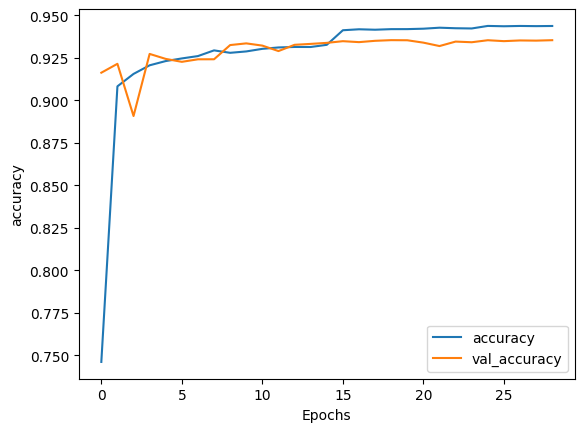

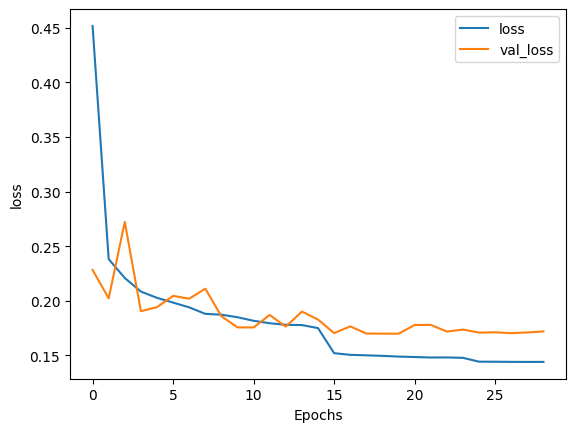

In [20]:
# Plot the accuracy and loss
plot_graphs(history_GlobalAveragePooling1D, "accuracy")
plot_graphs(history_GlobalAveragePooling1D, "loss")

# Model Embedding + Conv1D

In [21]:
kernel_size = 5
filters = 128

# Initialize the model
model_Conv1D = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_Conv1D.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_Conv1D.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10000, 16)         160000    
                                                                 
 conv1d (Conv1D)             (None, 9996, 128)         10368     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                      

In [22]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Model Embedding + Conv1D.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=10, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [23]:
num_epochs = 100

# Train the model
history_Conv1D = model_Conv1D.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), callbacks=callbacks)

Epoch 1/100
5802/5802 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9309
Epoch 1: val_accuracy improved from -inf to 0.93530, saving model to Model Embedding + Conv1D.h5
5802/5802 [==============================] - 174s 29ms/step - loss: 0.1804 - accuracy: 0.9309 - val_loss: 0.1678 - val_accuracy: 0.9353 - lr: 0.0010
Epoch 2/100
5801/5802 [============================>.] - ETA: 0s - loss: 0.1314 - accuracy: 0.9509
Epoch 2: val_accuracy improved from 0.93530 to 0.94523, saving model to Model Embedding + Conv1D.h5
5802/5802 [==============================] - 170s 29ms/step - loss: 0.1314 - accuracy: 0.9509 - val_loss: 0.1463 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 3/100
5801/5802 [============================>.] - ETA: 0s - loss: 0.1075 - accuracy: 0.9601
Epoch 3: val_accuracy did not improve from 0.94523
5802/5802 [==============================] - 170s 29ms/step - loss: 0.1075 - accuracy: 0.9601 - val_loss: 0.1657 - val_accuracy: 0.9402 - lr: 0.0010
Epoch 4/

In [24]:
# Evaluate the model
results_Conv1D = model_Conv1D.evaluate(testing_padded, testing_labels)

# print results
print(f'Test results - Loss: {results_Conv1D[0]} - Accuracy: {100*results_Conv1D[1]}%')

1451/1451 [==============================] - 17s 11ms/step - loss: 0.1463 - accuracy: 0.9452
Test results - Loss: 0.14631249010562897 - Accuracy: 94.52332258224487%


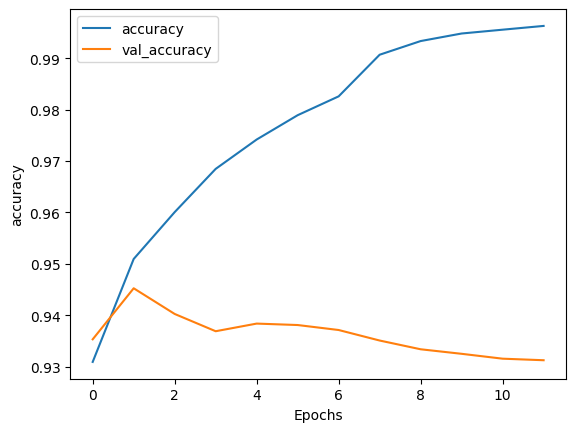

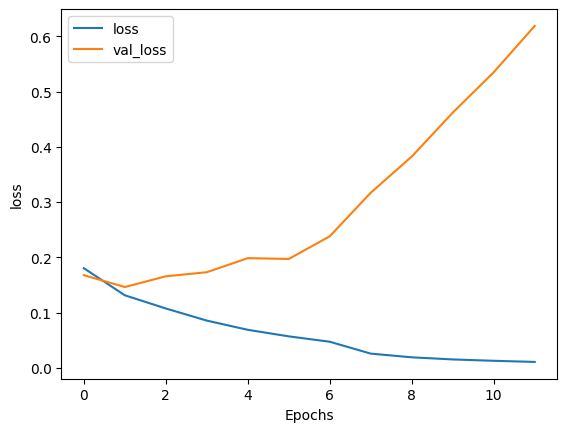

In [25]:
# Plot the accuracy and loss
plot_graphs(history_Conv1D, "accuracy")
plot_graphs(history_Conv1D, "loss")

# Testing Model

In [31]:
# Load all model
model_base = tf.keras.models.load_model('Basic-Model-Embeding-Layers.h5')
model_GlobalAveragePooling1D = tf.keras.models.load_model('Model-Basic-Global-Average-Pooling.h5')
model_Conv1D = tf.keras.models.load_model('Model-Embedding-Conv1D.h5')

## Testing Base Model

In [33]:
# Define the tweet
twt = ['I will kill myself']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Predict the sentiment
prediction_base = model_base.predict(twt)

# Print the prediction
if(np.argmax(prediction_base) == 0):
    print("Potential Suicide Post")
elif (np.argmax(prediction_base) == 1):
    print("Non Suicide Post")

1/1 [==============================] - 0s 15ms/step
Potential Suicide Post


## Testing Basic + Global Average Pooling

In [34]:
# Testing Basic + Global Average Pooling
prediction_Globalave = model_GlobalAveragePooling1D.predict(twt)

# Print the prediction
if(np.argmax(prediction_Globalave) == 0):
    print("Potential Suicide Post")
elif (np.argmax(prediction_Globalave) == 1):
    print("Non Suicide Post")

1/1 [==============================] - 0s 53ms/step
Potential Suicide Post


## Testing Embeding + Conv1D

In [35]:
# Testing Embeding + Conv1D
prediction_EmbedCov1D = model_Conv1D.predict(twt)

# Print the prediction
if(np.argmax(prediction_EmbedCov1D) == 0):
    print("Potential Suicide Post")
elif (np.argmax(prediction_EmbedCov1D) == 1):
    print("Non Suicide Post")

1/1 [==============================] - 0s 221ms/step
Potential Suicide Post


# Comparation Model

In [37]:
# Compare model
results=pd.DataFrame({'Model':['Base Model','Base + Global Average Pooling','Base + CNN'],
                     'Accuracy Score':[results_base[1],results_GlobalAveragePooling1D[1],results_Conv1D[1]]})
result_df=results.sort_values(by='Accuracy Score', ascending=False)
result_df=result_df.set_index('Model')
result_df

,Accuracy Score
Model,
Base + CNN,0.945233
Base Model,0.940989
Base + Global Average Pooling,0.935387
